In [1]:
#!/usr/bin/env python
from tensorflow_probability.substrates import jax as tfp

from iminuit import Minuit
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax.scipy import optimize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.smaller_network_eqx import get_network_eval_v_fn
from likelihood_conv_mpe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
from dom_track_eval import get_eval_network_doms_and_track

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

# Number of scan points on 1D
n_eval = 50 # making it a 100x100 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad


In [2]:
# Event Index.
event_index = 0

# Get network and eval logic.
dtype = jnp.float64
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network_eqx/tpn_smallest_default_tree_start_epoch_192', dtype=jnp.float64)
#eval_network_v = get_network_eval_v_fn(bpath="/home/storage/hans/photondata/train_in_jax/cache_z_and_dist_penalty/w_z_and_dist_penalty_tpn_smallest_default_tree_start_epoch_190.eqx", dtype=jnp.float64)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=jnp.float64)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

muon energy: 2.1 TeV
n_doms 29
original seed vertex: [-1277.51128861 -1390.39564543 -1675.98024553]
shifted seed vertex: [ -53.74394146  162.12452256 -233.73599134]


In [3]:
# Combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())

# Setup likelihood
neg_llh_grad = jax.jit(jax.grad(get_neg_c_triple_gamma_llh(eval_network_doms_and_track)))
neg_llh_v = jax.jit(jax.vmap(neg_llh_grad, (0, None, None, None), 0))

In [4]:
zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

grads = neg_llh_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

grads0 = grads[:,0].reshape(X.shape)
grads1 = grads[:,1].reshape(X.shape)


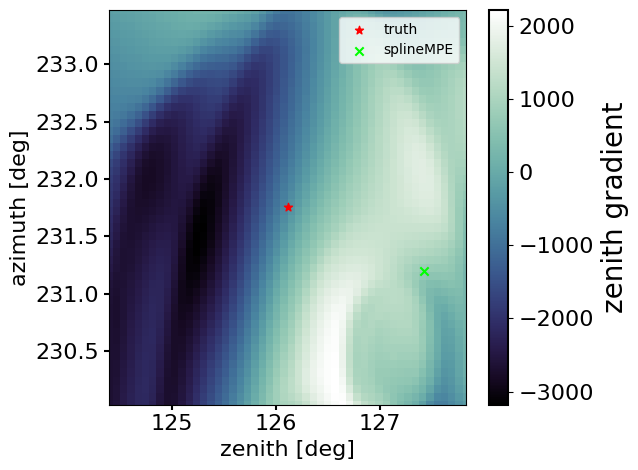

In [5]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads0, 
                   vmin=np.amin(grads0), vmax=np.amax(grads0), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("zenith gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [6]:
print(grads0)

[[-2637.71037189 -2580.22624585 -2422.17970912 ...  -608.68233338
   -428.20277589  -284.81751487]
 [-2656.68396705 -2597.72694008 -2442.40406343 ...  -513.29709046
   -328.3066803   -181.78586703]
 [-2666.56873554 -2610.1634557  -2463.15042197 ...  -424.7910912
   -224.34915848   -61.73538688]
 ...
 [ -300.89832929  -272.97873014  -243.2808134  ...   249.76404082
    313.81037825   378.8108843 ]
 [ -260.39779209  -231.96601201  -201.94238921 ...   198.96961114
    267.73868864   336.90424569]
 [ -220.71174541  -191.85970729  -161.26065281 ...   159.77497237
    230.39915623   300.73419258]]


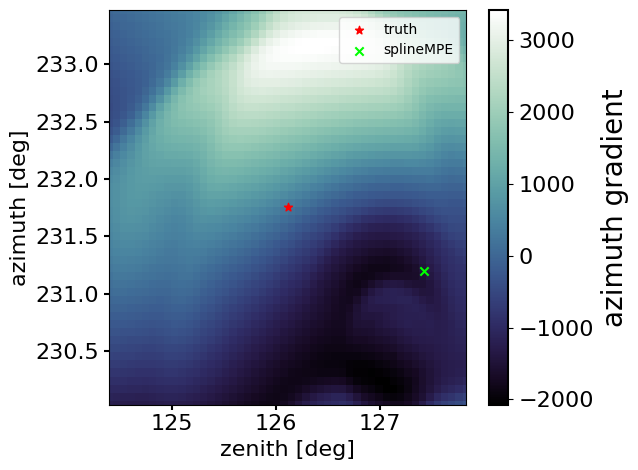

In [7]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads1, 
                   vmin=np.amin(grads1), vmax=np.amax(grads1), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("azimuth gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

@jax.jit
def finite_difference_grad(track_direction, track_pos, track_time, fitting_event_data):
    eps = 1.e-5
    
    track_direction1 = track_direction + jnp.array([eps, 0.0])
    track_direction2 = track_direction - jnp.array([eps, 0.0])
    fval1 = neg_llh(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh(track_direction2, track_pos, track_time, fitting_event_data)
    grad1 = (fval1 - fval2)/(2*eps)

    track_direction1 = track_direction + jnp.array([0.0, eps])
    track_direction2 = track_direction - jnp.array([0.0, eps])
    fval1 = neg_llh(track_direction1, track_pos, track_time, fitting_event_data)
    fval2 = neg_llh(track_direction2, track_pos, track_time, fitting_event_data)
    grad2 = (fval1 - fval2)/(2*eps)
    
    return jnp.array([grad1, grad2])

finite_diff_grad_v = jax.jit(jax.vmap(finite_difference_grad, (0, None, None, None), 0))

In [9]:
print(finite_difference_grad(track_src, centered_track_pos, centered_track_time, fitting_event_data))
print(neg_llh_grad(track_src, centered_track_pos, centered_track_time, fitting_event_data))

[-537.68498769  317.43351356]
[-537.68489668  317.43348916]


In [10]:
grads = finite_diff_grad_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)
grads0 = grads[:,0].reshape(X.shape)
grads1 = grads[:,1].reshape(X.shape)

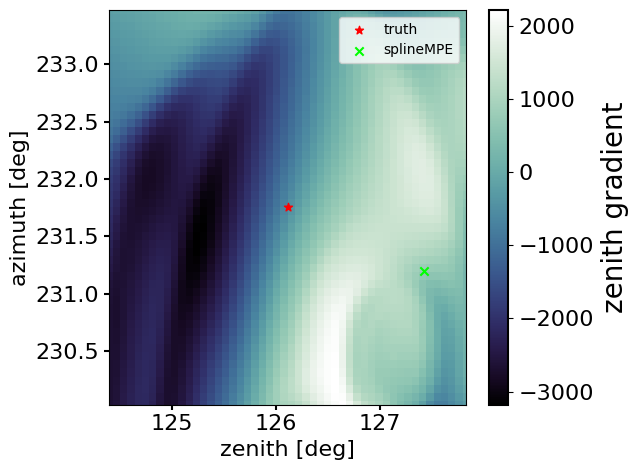

In [11]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads0, 
                   vmin=np.amin(grads0), vmax=np.amax(grads0), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("zenith gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

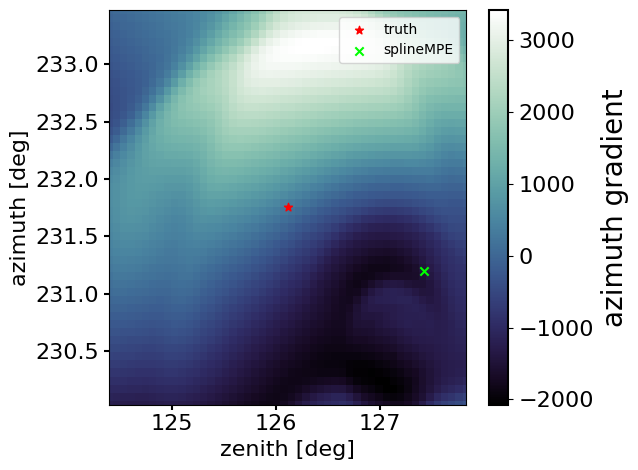

In [12]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), grads1, 
                   vmin=np.amin(grads1), vmax=np.amax(grads1), shading='auto', cmap=cx)

cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("azimuth gradient", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
np.rad2deg(1.e-2)

np.float64(0.5729577951308232)